# Training: Classical case

## Preparation

We start with importing PyTorch and specifying some training hyperparameters.

In [1]:
import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0

### Input data

Let's read the data and print some example sentences.

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../examples/datasets/mc_train_data.txt')
val_labels, val_data = read_data('../examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/mc_test_data.txt')

In [ ]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [3]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

Targets are represented as 2-dimensional arrays:

In [4]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

### Creating and parameterising diagrams

In [5]:
from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

train_diagrams = parser.sentences2diagrams(train_data)
val_diagrams = parser.sentences2diagrams(val_data)
test_diagrams = parser.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


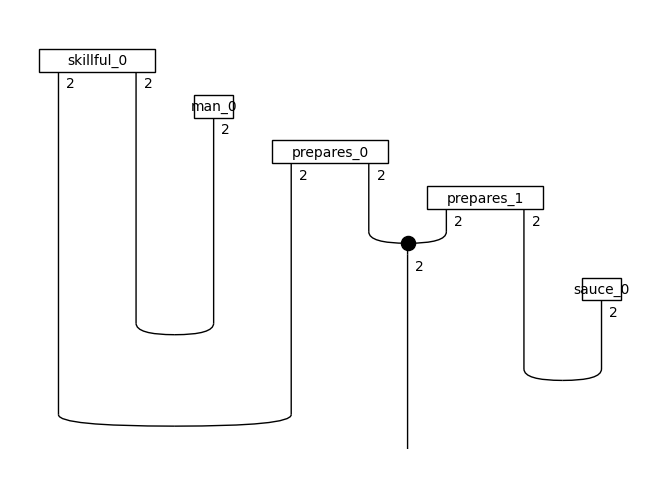

In [6]:
from discopy.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

## Training

### Instantiate model

In [7]:
from lambeq import PytorchModel

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

### Define evaluation metric

Optionally, we can provide a dictionary of callable evaluation metrics with the signature ``metric(y_hat, y)``.

In [8]:
sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

### Initialise trainer

In [9]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

### Create datasets

In [10]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [11]:
trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=5)

Epoch 5:   train/loss: 0.6518   valid/loss: 0.7119   train/acc: 0.5643   valid/acc: 0.5500
Epoch 10:  train/loss: 0.5804   valid/loss: 0.6197   train/acc: 0.5714   valid/acc: 0.6167
Epoch 15:  train/loss: 0.3311   valid/loss: 0.4577   train/acc: 0.8643   valid/acc: 0.7667
Epoch 20:  train/loss: 0.1054   valid/loss: 0.2346   train/acc: 0.9500   valid/acc: 0.9333
Epoch 25:  train/loss: 0.1346   valid/loss: 0.0438   train/acc: 0.9857   valid/acc: 1.0000
Epoch 30:  train/loss: 0.0005   valid/loss: 0.0283   train/acc: 0.9929   valid/acc: 1.0000

Training completed!


## Results

Finally, we visualise the results and evaluate the model on the test data.

Test accuracy: 1.0


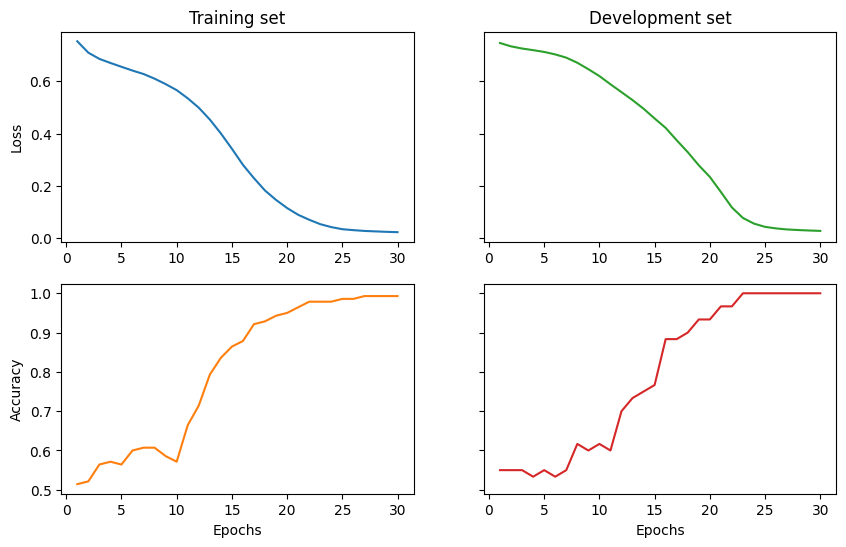

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())

## Adding custom layers to the model

In [13]:
class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds.float())
        return preds

The rest follows the same procedure as explained above, i.e. initialise a trainer, fit the model and visualise the results.

In [14]:
custom_model = MyCustomModel.from_diagrams(all_circuits)
custom_model_trainer = PytorchTrainer(
        model=custom_model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

custom_model_trainer.fit(train_dataset, val_dataset, log_interval=5)

Epoch 5:   train/loss: 0.6729   valid/loss: 0.7965   train/acc: 0.6429   valid/acc: 0.3833
Epoch 10:  train/loss: 0.4602   valid/loss: 1.0563   train/acc: 0.7500   valid/acc: 0.4333
Epoch 15:  train/loss: 0.4580   valid/loss: 1.0329   train/acc: 0.8286   valid/acc: 0.4667
Epoch 20:  train/loss: 0.1645   valid/loss: 1.0594   train/acc: 0.9429   valid/acc: 0.7667
Epoch 25:  train/loss: 0.1098   valid/loss: 1.2642   train/acc: 0.9429   valid/acc: 0.7333
Epoch 30:  train/loss: 0.1957   valid/loss: 1.3476   train/acc: 0.9429   valid/acc: 0.7333

Training completed!


Test accuracy: 1.0


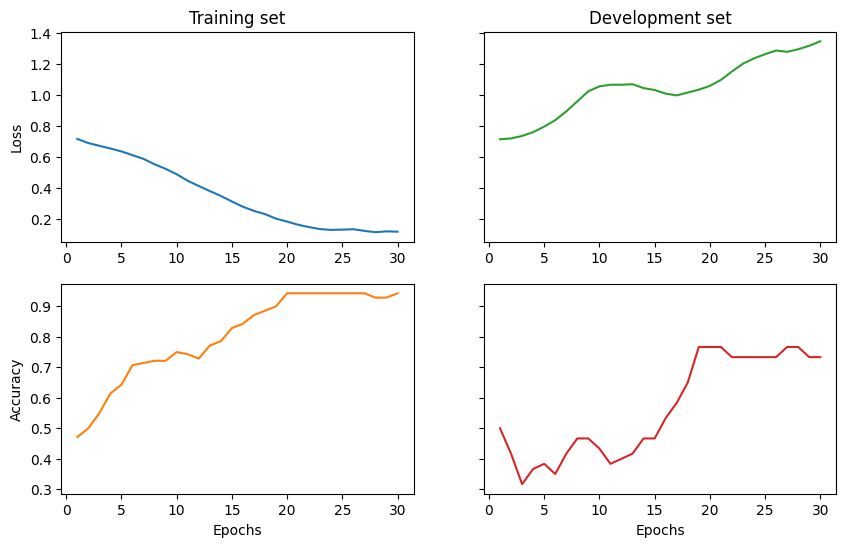

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, custom_model_trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, custom_model_trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, custom_model_trainer.val_costs, color=next(colours))
ax_br.plot(range_, custom_model_trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())